In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import keras.backend as k
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding,Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
def softmax_over_time(x):
    e = k.exp(x - k.max(x, axis=1,keepdims=True))
    s = k.sum(e, axis=1, keepdims=True)
    return e/s

In [4]:
BATCH_SIZE = 64  
EPOCHS = 100  
LATENT_DIM = 256  
NUM_SAMPLES = 30000
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
LATENT_DIM_DECODER = 256 

In [5]:
input_texts = [] 
target_texts = [] 
target_texts_inputs = []

In [6]:
t = 0
for line in open('ita-eng/ita.txt',encoding='utf-8'):
    t += 1
    if t > NUM_SAMPLES:
        break

    if '\t' not in line:
        continue

    input_text, translation = line.rstrip().split('\t')

    target_text = translation + ' <eos>'
    target_text_input = '<sos> ' + translation

    input_texts.append(input_text)
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))

num samples: 30000


In [7]:
#### input- English
#### output- Italian

In [8]:
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

In [9]:
word2idx_inputs = tokenizer_inputs.word_index
print('{} unique input tokens.'.format(len(word2idx_inputs)))

3113 unique input tokens.


In [10]:
max_len_input = max(len(s) for s in input_sequences)

In [11]:
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) 
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

Found 9727 unique output tokens.


In [12]:
num_words_output = len(word2idx_outputs) + 1    ####because the encoding starts from 1
max_len_target = max(len(s) for s in target_sequences)

In [13]:
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

encoder_inputs.shape: (30000, 5)
encoder_inputs[0]: [   0    0    0    0 1382]


In [14]:
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_inputs[0]: [   2 1839    0    0    0    0    0    0    0]
decoder_inputs.shape: (30000, 9)


In [15]:
decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

In [16]:
word2vec = {}
with open('glove.6B/glove.6B.100d.txt',encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('found {} words in embedding'.format(len(word2vec)))

found 400000 words in embedding


In [17]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = word2vec.get(word)
    if embedding_vector is not None:                                                        
        embedding_matrix[i] = embedding_vector  # words not found in embedding index will be all zeros.

In [18]:
embedding_layer = Embedding(num_words,EMBEDDING_DIM,weights=[embedding_matrix],input_length=max_len_input,)

W0814 00:55:00.351941 14044 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [19]:
decoder_targets_one_hot = np.zeros((len(input_texts),max_len_target,num_words_output)) ####for using categorical crossentropy

In [20]:
for i, d in enumerate(decoder_targets):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [21]:
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder =  Bidirectional(LSTM(LATENT_DIM, return_sequences=True))
encoder_outputs = encoder(x)

W0814 00:55:01.544985 14044 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0814 00:55:01.550966 14044 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0814 00:55:01.569914 14044 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0814 00:55:01.571919 14044 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [22]:
decoder_inputs_placeholder = Input(shape=(max_len_target,))
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

In [23]:
attn_repeat_layer = RepeatVector(max_len_input)
attn_concat_layer = Concatenate(axis=-1)  
attn_dense1 = Dense(10, activation='tanh')
attn_dense2 = Dense(1, activation=softmax_over_time)
attn_dot = Dot(axes=1)

In [24]:
def one_step_attention(h, st_1):

    st_1 = attn_repeat_layer(st_1)

    x = attn_concat_layer([h, st_1])

    x = attn_dense1(x)

    alphas = attn_dense2(x)

    context = attn_dot([alphas, h])

    return context

In [25]:
decoder_lstm = LSTM(LATENT_DIM_DECODER, return_state=True)
decoder_dense = Dense(num_words_output, activation='softmax')

initial_s = Input(shape=(LATENT_DIM_DECODER,), name='s0')
initial_c = Input(shape=(LATENT_DIM_DECODER,), name='c0')
context_last_word_concat_layer = Concatenate(axis=2)

In [26]:
s = initial_s
c = initial_c

In [27]:
outputs = []
for t in range(max_len_target): # Ty times
    context = one_step_attention(encoder_outputs, s)
    selector = Lambda(lambda x: x[:, t:t+1])
    xt = selector(decoder_inputs_x)
    decoder_lstm_input = context_last_word_concat_layer([context, xt])

    o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s, c])

    decoder_outputs = decoder_dense(o)
    outputs.append(decoder_outputs)

In [28]:
def stack_and_transpose(x):
    x = k.stack(x) 
    x = k.permute_dimensions(x, pattern=(1, 0, 2)) 
    return x

In [29]:
stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)

In [30]:
model = Model(inputs=[encoder_inputs_placeholder,decoder_inputs_placeholder,initial_s, initial_c,],outputs=outputs)

In [31]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

W0814 00:55:05.655313 14044 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [33]:
z = np.zeros((NUM_SAMPLES, LATENT_DIM_DECODER))

In [35]:
r = model.fit([encoder_inputs, decoder_inputs, z, z], decoder_targets_one_hot,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=0.2)

Train on 24000 samples, validate on 6000 samples
Epoch 1/100
24000/24000 [==============================] - 289s 12ms/step - loss: 2.6947 - acc: 0.6287 - val_loss: 3.0704 - val_acc: 0.6141
Epoch 2/100
24000/24000 [==============================] - 277s 12ms/step - loss: 2.3528 - acc: 0.6889 - val_loss: 2.9479 - val_acc: 0.6269
Epoch 3/100
24000/24000 [==============================] - 284s 12ms/step - loss: 2.2321 - acc: 0.6937 - val_loss: 2.8542 - val_acc: 0.6329
Epoch 4/100
24000/24000 [==============================] - 249s 10ms/step - loss: 2.1570 - acc: 0.6939 - val_loss: 2.7979 - val_acc: 0.6362
Epoch 5/100
24000/24000 [==============================] - 248s 10ms/step - loss: 2.1005 - acc: 0.6956 - val_loss: 2.7595 - val_acc: 0.6391
Epoch 6/100
24000/24000 [==============================] - 154s 6ms/step - loss: 2.0280 - acc: 0.7065 - val_loss: 2.6150 - val_acc: 0.6747
Epoch 7/100
24000/24000 [==============================] - 145s 6ms/step - loss: 1.8093 - acc: 0.7414 - val_loss

24000/24000 [==============================] - 240s 10ms/step - loss: 0.1823 - acc: 0.8990 - val_loss: 1.8004 - val_acc: 0.7699
Epoch 60/100
24000/24000 [==============================] - 242s 10ms/step - loss: 0.1815 - acc: 0.8994 - val_loss: 1.7911 - val_acc: 0.7712
Epoch 61/100
24000/24000 [==============================] - 243s 10ms/step - loss: 0.1811 - acc: 0.8994 - val_loss: 1.7806 - val_acc: 0.7725
Epoch 62/100
24000/24000 [==============================] - 242s 10ms/step - loss: 0.1807 - acc: 0.8993 - val_loss: 1.7813 - val_acc: 0.7716
Epoch 63/100
24000/24000 [==============================] - 241s 10ms/step - loss: 0.1799 - acc: 0.8993 - val_loss: 1.8155 - val_acc: 0.7683
Epoch 64/100
24000/24000 [==============================] - 242s 10ms/step - loss: 0.1799 - acc: 0.8989 - val_loss: 1.8157 - val_acc: 0.7681
Epoch 65/100
24000/24000 [==============================] - 237s 10ms/step - loss: 0.1797 - acc: 0.8991 - val_loss: 1.8301 - val_acc: 0.7693
Epoch 66/100
24000/24000 [

In [36]:
model.save('attention_model.h5')

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 's0:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'c0:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_2/while/Exit_3:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_2/while/Exit_4:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.

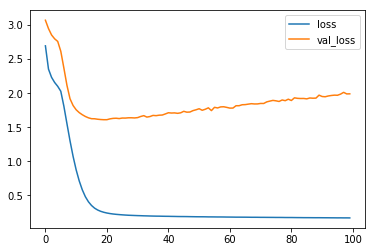

In [37]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

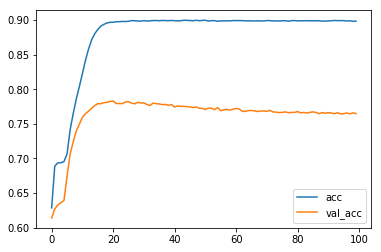

In [38]:
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [39]:
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)

In [40]:
encoder_outputs_as_input = Input(shape=(max_len_input, LATENT_DIM * 2,))
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [41]:
import tensorflow as tf

In [42]:
context = one_step_attention(encoder_outputs_as_input, initial_s)
decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])
o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s,initial_c])
decoder_outputs = decoder_dense(o)

In [43]:
decoder_model = Model(inputs=[decoder_inputs_single,encoder_outputs_as_input,initial_s,initial_c],outputs=[decoder_outputs, s, c])

In [46]:
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [47]:
def decode_sequence(input_seq):
    enc_out = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    eos = word2idx_outputs['<eos>']
    s = np.zeros((1, LATENT_DIM_DECODER))
    c = np.zeros((1, LATENT_DIM_DECODER))

    output_sentence = []
    for _ in range(max_len_target):
        o, s, c = decoder_model.predict([target_seq, enc_out, s, c])

        idx = np.argmax(o.flatten())
        if eos == idx:
            break

        word = ''
        if idx > 0:
            word = idx2word_trans[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [48]:
while True:
    i = np.random.choice(len(input_texts))
    input_seq = encoder_inputs[i:i+1]
    translation = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[i])
    print('Predicted translation:', translation)
    print('Actual translation:', target_texts[i])

    ans = input("Continue? [Y/n]")
    if ans and ans.lower().startswith('n'):
        break


-
Input sentence: I'm at my place.
Predicted translation: io sono sulla mia strada.
Actual translation: Sono a casa. <eos>
Continue? [Y/n]Y
-
Input sentence: You were lucky.
Predicted translation: eri fortunata.
Actual translation: Lei era fortunato. <eos>
Continue? [Y/n]Y
-
Input sentence: I'm forgetful.
Predicted translation: sono smemorata.
Actual translation: Io sono smemorata. <eos>
Continue? [Y/n]y
-
Input sentence: See you later.
Predicted translation: ci vediamo più tardi.
Actual translation: Ci vediamo più tardi. <eos>
Continue? [Y/n]y
-
Input sentence: Here's your tea.
Predicted translation: ecco il vostro cibo.
Actual translation: Ecco il vostro tè. <eos>
Continue? [Y/n]
-
Input sentence: I tried that.
Predicted translation: io l'ho provato.
Actual translation: Io lo provai. <eos>
Continue? [Y/n]
-
Input sentence: You'll go far.
Predicted translation: andrete lontano.
Actual translation: Andrete lontano. <eos>
Continue? [Y/n]y
-
Input sentence: Tom refused.
Predicted transla